# Лабораторная работа 6. Параллельные вычисления на Python на графических процессорах

Для различных вычислительных задач Google Colab предоставляет доступ к своим графическим процессорам. В бесплатной версии для пользоватетей доступен графический процессор T4, который можно подключить на 4 часа.

Чтобы включить, перейдите в меню ""Среда выполнения > Сменить среду выполнения" и выберите "T4 графический процессор".

## 1. Numba + CUDA


Numba - компилятор для функций Python, которые работают с числами и массивами, позволяя ускорять код, написанные на чистом Python.

Numba генерирует оптимизированный (насколько возможно) машинный код, используя специальный LLVM-компилятор и получая достаточно высокопроизводительный код без необходимости перехода на такие языки, как C/C++ или Fortran.

Главные преимущества `numba`:

+ JIT-компиляция - **компиляция по требованию/ленивая компиляция**;
+ Генерация нативного кода для CPU и GPU;
+ Интеграция со стеком научных библиотек через NumPy.

### 1.1 Первоначальная настройка

Google Colab по-умолчанию, не запускает numba и CUDA, потому что не может найти библиотеки `libdevice` и `libnvvm.so`. Поэтому подключаем библиотеки вручную.

Сначала найдем пути к файлам библиотек в файловой системе среды выполнения. Восклицательный знак в начале строки говорит о том, что данная команда должна выполняться командной строкой, а не Jupyter.

In [ ]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

find: ‘/proc/64/task/64/net’: Invalid argument
find: ‘/proc/64/net’: Invalid argument
/usr/local/lib/python3.11/dist-packages/nvidia/cuda_nvcc/nvvm/libdevice
/usr/local/cuda-12.5/nvvm/libdevice
find: ‘/proc/64/task/64/net’: Invalid argument
find: ‘/proc/64/net’: Invalid argument
/usr/local/lib/python3.11/dist-packages/nvidia/cuda_nvcc/nvvm/lib64/libnvvm.so
/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so


Зная пути к файлам библиотеки, укажем значения для переменных окружения в Python.

In [ ]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-12.5/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-12.5/nvvm/lib64/libnvvm.so"

Готово! Теперь можем приступать к работе с numba + CUDA

Поскольку numba явно зависит от CUDA Runtime библиотек, то иногда требуется настроить среду таким образом, чтобы работала совместимость пакета и CUDA, к примеру, так:

In [ ]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

# Опциональные параметры, отключают предупреждения
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0
config.DISABLE_PERFORMANCE_WARNINGS = 1

### 1.2 Универсальные функции в NumPy

Библиотека NumPy содержит универсальные функции (ufuncs), которые позволяют выполнять определнные действия над целыми массивами.

Например, если есть массив чисел и необходимо найти их квадратные корни, то без использования NumPy мы бы это реализовали следующим образом

In [ ]:
import math
x = list(range(0, 10))
[math.sqrt(xx) for xx in x]

[0.0,
 1.0,
 1.4142135623730951,
 1.7320508075688772,
 2.0,
 2.23606797749979,
 2.449489742783178,
 2.6457513110645907,
 2.8284271247461903,
 3.0]

С использованием NumPy и универсальных функций код принимает следующий вид

In [ ]:
import numpy as np
x = np.arange(10)
np.sqrt(x)

array([0.        , 1.        , 1.41421356, 1.73205081, 2.        ,
       2.23606798, 2.44948974, 2.64575131, 2.82842712, 3.        ])

Помимо синтаксического удобства универсальные функции NumPy оказываются быстрее, чем использование встроенных в Python функций. Это достигается за счет того, что универсальные функции в NumPy реализованы на С и Fortran.

Сравните время выполнения операции вычисления квадратного корня для массива из 10 миллионов чисел на чистом Python и с использованием NumPy.

* `%timeit` - команда Jupyter, которая позволяет узнать время выполнения кода, заданного далее в этой же строке. Команда запускает *n* раз код и выводит усредненный результат нескольких лучших запусков.
* Чтобы измерить время выполнения всей ячейки кода, требуется добавить дополнительный символ процента, получая `%%timeit`
* Для управления числом запусков, которая команда выполнит, используется флаг `-n`, после которого идет число запусков

In [ ]:
x = np.arange(1e7, dtype=np.float32)
%timeit [math.sqrt(item) for item in x]
%timeit np.sqrt(x)

1.68 s ± 415 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.8 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Результат с использованием NumPy оказался приблизительно в 100 раз быстрее. И при этом универсальные функции даже не распараллелены - вычисление квадратных корней запускается последовательно в одном потоке на CPU.

Теперь мы используем библиотеку numba, чтобы создать собственную универсальную функцию для вычисления квадратного корня, которые будут выполняться в нескольких потоках на GPU.

### 1.3. Пример использования numba: параллельное вычисление квадратных корней на GPU

Для создания универсальной функции `numba` необходимо использовать декоратор `@vectorize`. По умолчанию, код компилируется под CPU с использованием одного потока.

In [ ]:
from numba import vectorize

@vectorize
def cpu_sqrt(x):
  return math.sqrt(x)

cpu_sqrt(x)

array([0.0000000e+00, 1.0000000e+00, 1.4142135e+00, ..., 3.1622771e+03,
       3.1622773e+03, 3.1622776e+03], dtype=float32)

Декоратор `@vectorize` имеет ряд параметров, в которых можно указать доступные наборы типов входных и выходных данных, а также архитектуру (`target`), под которую компилируется функция.

Поддерживаемые архитектуры:
* `cpu` - однопоточное выполнение на CPU
* `parallel` - многопоточное выполнение на CPU
* `cuda` - многопоточное выполнение на GPU с использованием CUDA

Рассмотрим многопоточное выполнение на GPU c использованием CUDA:

In [ ]:
@vectorize(target='cuda')
def gpu_sqrt(x):
  return math.sqrt(x)

gpu_sqrt(x)

TypeError: No matching version.  GPU ufunc requires array arguments to have the exact types.  This behaves like regular ufunc with casting='no'.

Получили ошибку выполнения. Она связана с тем, что при компиляции с архитектурами `parallel` и `cuda` необходимо задать допустимые варианты типов входных и выходных данных в формате "тип входных данных(тип выходных данных)".

Исправим предыдущий код, указав `float32` в качестве типа для входного аргумента и результата функции.

In [ ]:
@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
  return math.sqrt(x)

gpu_sqrt(x)

array([0.0000000e+00, 1.0000000e+00, 1.4142135e+00, ..., 3.1622771e+03,
       3.1622773e+03, 3.1622776e+03], dtype=float32)

Измерим время выполнения функции `gpu_sqrt` для массива из 10 миллионов чисел



In [ ]:
%timeit -n 10 gpu_sqrt(x)

29.3 ms ± 583 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Сравним значение для CPU

In [ ]:
%timeit -n 10 np.sqrt(x)

9.89 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Так, стоп! Ведь на GPU же должно было быть быстрее, а в нашем случае приблизительно в 3 раза медленнее, чем на CPU!

Дело в том, что под капотом процесс вычисления функции квадратного корня на GPU состоит из следующих этапов:
* Загрузка исходных данных (в нашем случае, массива `x`) в память GPU
* Параллельное вычисление квадратного корня на GPU для каждого элемента массива `x`
* Выгрузка массива из GPU в оперативную память

Операции загрузки и выгрузки данных в GPU довольно трудозатратны, поэтому использование GPU для слишком простых задач оказывается нецелесообразным, так как передача данных занимает гораздо больше времени, чем сами вычисления.

Также на время выполнения влияет тип данных, поскольку видеокарты специфическим образом обрабатывают числа с плавающей точкой, из-за чего часто вместо float32/float64 берут float16, который обрабатывается хорошо на видеокартах.

## 1.4. Пример: вычисление полярных координат на GPU

Пусть имеется $10^7$ точек на плоскости, координаты которых заданы в декартовой системе координат. Требуется вычислить полярные координаты этих точек.

Прежде всего, сформируем входной массив точек

In [ ]:
points = np.random.multivariate_normal([0, 0], [[3., 2.5], [2.5, 3.]], 10**7).astype(np.float16)

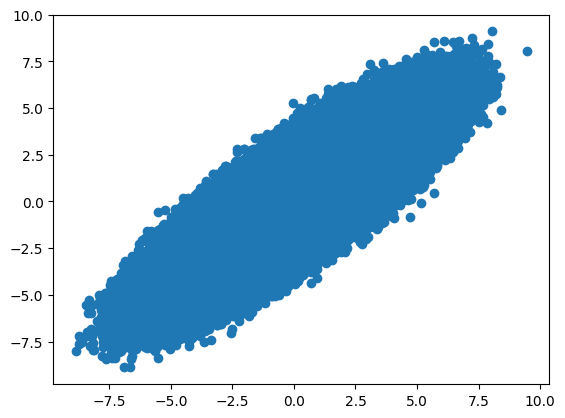

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(points[:, 0], points[:, 1])
plt.show()

Полярные координаты вычисляются по формулам:

$R = \sqrt{x^2 + y^2}$

$\phi = arctan2(y, x)$

`R` получается довольно просто вычислением квадратного корня. А для вычисления полярного угла нам необходимо использовать функцию `arctan2`

С использованием `NumPy` нахождение полярных координат можно реализовать следующим образом

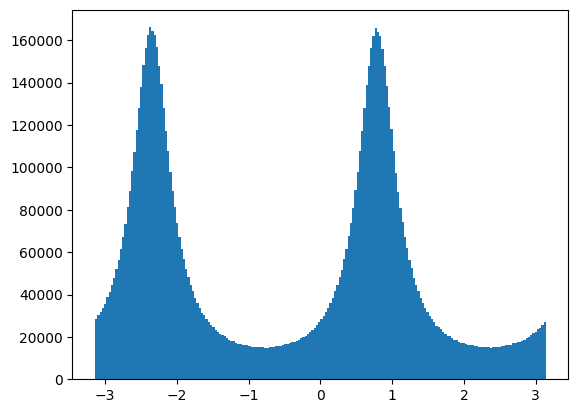

In [ ]:
phi = np.arctan2(points[:, 1], points[:, 0])
_ = plt.hist(phi, bins=200)

Теперь реализуем GPU версию с использованием numba + CUDA

In [ ]:
@vectorize(['float64(float64, float64)',
            'float32(float32, float32)',
            'float16(float16, float16)'], target='cuda')
def gpu_arctan2(y, x):
  return math.atan2(y, x)

phi = gpu_arctan2(points[:, 1], points[:, 0])

ValueError: Array contains non-contiguous buffer and cannot be transferred as a single memory region. Please ensure contiguous buffer with numpy .ascontiguousarray()

И... получили ошибку. По её описанию становится ясно, что массивы `points[:, 0]` и `points[:, 1]` не хранятся в непрерывной области памяти. Поэтому нам нужно последовать рекомендации и сохранить массив в непрерывной области памяти, используя `np.ascontiguousarray()`.

Следует запомнить, что CUDA работает только с массивами, хранящимися в **непрерывной** области памяти. Такими массивами являются массивы в С/Fortran или те же массивы в NumPy до вычисления их срезов.

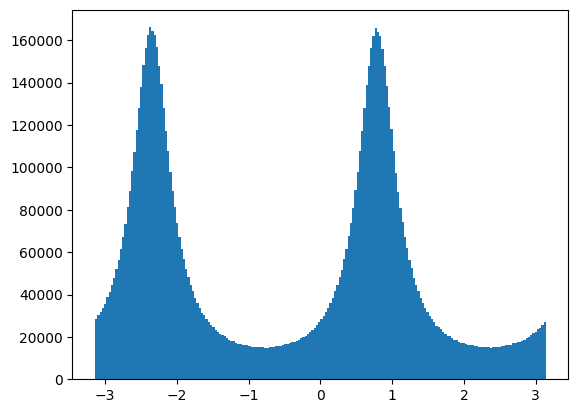

In [ ]:
x = np.ascontiguousarray(points[:, 0])
y = np.ascontiguousarray(points[:, 1])
phi = gpu_arctan2(y, x)
_ = plt.hist(phi, bins=200)

Теперь код работает и возвращает тот же самый результат, что и CPU реализация.

Сравним время выполнения

In [ ]:
# На float16
x = x.astype(np.float16)
y = y.astype(np.float16)
%timeit gpu_arctan2(y, x)
%timeit np.arctan2(y, x)

17 ms ± 612 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
583 ms ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# На float32
x = x.astype(np.float32)
y = y.astype(np.float32)
%timeit gpu_arctan2(y, x)
%timeit np.arctan2(y, x)

39.1 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.2 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# На float64
x = x.astype(np.float64)
y = y.astype(np.float64)
%timeit gpu_arctan2(y, x)
%timeit np.arctan2(y, x)

79.7 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
54.7 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
points = points.astype(np.float16)
%timeit [math.atan2(point[1], point[0]) for point in points]
points = points.astype(np.float32)
%timeit [math.atan2(point[1], point[0]) for point in points]
points = points.astype(np.float64)
%timeit [math.atan2(point[1], point[0]) for point in points]

4.88 s ± 935 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.82 s ± 838 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.53 s ± 610 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Как можно увидеть, в зависимости от типа данных, GPU и NumPy CPU ведут себя по-разному, при этом всегда уделывая чистый Python.

Таким образом, для того, чтобы эффективно использовать GPU, вычисления должны быть сложными и идти на большом наборе данных с применением правильного типа данных.

### 1.4. Обобщенные универсальные функции

Обычные универсальные функции применяются для каждого элемента входного массива и возвращают скаляр. Однако на практике зачастую нужно работать с подмассивами входного массива и возвращать данные в разных измерениях.

Вернемся к примеру с вычислением полярных координат. Реализованная нами функция позволяет вычислить только полярный угол, но в полноценной реализации функции вычисления полярных координат нам нужно также вычислять радиальную компоненту.

Для реализации обобщенных универсальных функций в numba используется декоратор `@guvectorize`. С его помощью можно реализовать функцию вычисления полярных координат.

In [ ]:
from numba import guvectorize

@guvectorize(['(float32[:], float32[:])'], '(n)->(n)', target='cuda')
def gpu_polar(vec, res):
  x = vec[0]
  y = vec[1]
  res[0] = math.sqrt(x**2 + y**2)
  res[1] = math.atan2(y, x)

Обратите внимание на отличия `@guvectorize` от `@vectorize`:
* Выходное значение передается в качестве параметра и изменяется in-place без выделения дополнительной памяти
* Требуется передавать сигнатуру операции. В нашем случае сигнатура `(n)->(n)` означает, что массив длины `n`, переданный в качестве первого аргумента функции, преобразуется в массив длины `n`, представленный вторым аргументом функции.

In [ ]:
polar_coords = gpu_polar(points.astype(np.float32))

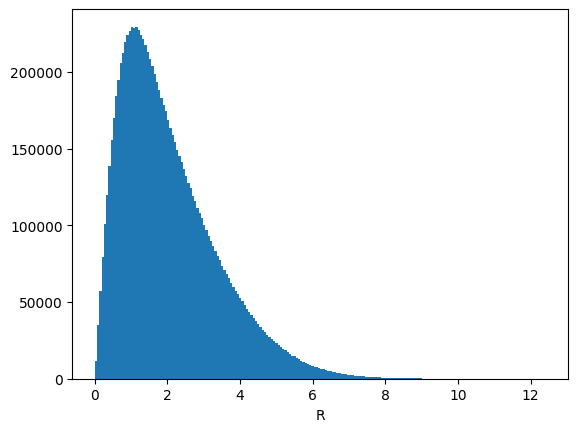

In [ ]:
_ = plt.hist(polar_coords[:,0], bins=200)
_ = plt.xlabel('R')

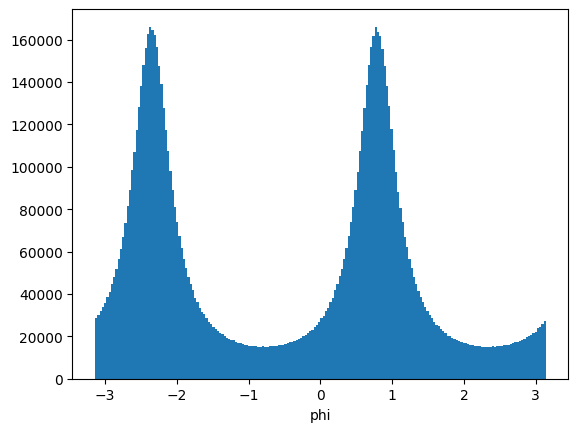

In [ ]:
_ = plt.hist(polar_coords[:,1], bins=200)
_ = plt.xlabel('phi')

## 1.5. Использование CUDA, управление памятью GPU

В первом примере мы упомянули, что при вызове функции на GPU numba автоматически копирует входнные и выходные данные в GPU. Библиотека numba также предоставляет возможность делать это вручную.

Модуль `numba.cuda` содержит функции для непосредственной работы с CUDA, в том числе функции копирования данных из RAM в GPU и обратно.

In [ ]:
from numba import cuda

x = np.arange(0, 1e6, 0.1, dtype=np.float32)
x_device = cuda.to_device(x)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(10000000,)
float32


Теперь запустим функцию `gpu_sqrt` с массивом, уже загруженным в GPU

In [ ]:
gpu_sqrt(x_device)

Сравним производительность

In [ ]:
%timeit gpu_sqrt(x_device)

1.46 ms ± 74.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%timeit gpu_sqrt(x)

27.6 ms ± 605 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Видим существенный прирост к производительности функции. Но numba по-прежнему создает новый массив на GPU и передает его обратно в память.

Создадим сами новый массив на GPU для выходных данных.

In [ ]:
out_device = cuda.device_array(shape=(int(1e7),), dtype=np.float32)

И передадим его в универсальную функцию с помощью аргумента `out`.

In [ ]:
gpu_sqrt(x_device, out=out_device)

In [ ]:
%timeit gpu_sqrt(x_device, out=out_device); cuda.synchronize()

565 µs ± 49.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Осталось лишь скопировать значения из GPU в память

In [ ]:
res = out_device.copy_to_host()
res

array([0.0000000e+00, 3.1622776e-01, 4.4721359e-01, ..., 9.9999982e+02,
       9.9999988e+02, 9.9999994e+02], dtype=float32)

### 1.6. Написание CUDA ядер

Универсальные функции - это очень удобно, но не все функции можно описать в виде универсальных. В таких случаях нам нужно работать с CUDA напрямую, используя функции из модуля `numba.cuda`.

Самое ключевое для понимания CUDA - следующая картинка:

![Thread Hierarchy](https://www.microway.com/wp-content/uploads/CUDA-GridBlockThread-Structure.png)

CUDA-ядро - функция, которая описывает логику работы одного **потока** (нить, thread). CUDA запустит ядро по **сетке потоков** (grid), состоящей из **блоков** (block) потоков. Потоки внутри одного блока могут обмениваться данными во время выполнения, в то время как потоки в разных блоках, как правило, никак не взаимодействуют друг с другом.

Важная часть решения задачи - определение размеров блока и сетки. Есть ряд общих рекоммендаций:
* размер блока должен быть кратен 32, наиболее используемые блоки размером между 128 и 512
* размер сетки должен быть таким, чтобы GPU использовалось по-максимуму, без простаивающих потоков.

Каждый поток и каждый блок имеют свой уникальный идентификатор, которые можно получить в коде из переменных `cuda.threadIdx` и `cuda.blockIdx` соответсвенно.

Размер блока можно получить из переменной `cuda.blockDim`. Значение для этой переменной будет одинаковым для всех потоков во всех блоках.

Размер сетки хранится в переменной `cuda.gridDim`.

Начнем с простого примера: напишем функцию, складывающую два массива

In [ ]:
@cuda.jit
def add(x, y, out):
  tid = cuda.threadIdx.x
  bid = cuda.blockIdx.x
  bw = cuda.blockDim.x
  i = tid + bid * bw
  if i < x.size: # если текущий поток не обрабатывает никаких входных данных, ничего не делаем
    out[i] = x[i] + y[i]

Подготовим входные данные

In [ ]:
N = int(1e7)
x = np.random.random(N).astype(np.float32)
y = np.random.random(N).astype(np.float32)

x_device = cuda.to_device(x)
y_device = cuda.to_device(y)
out = cuda.device_array_like(x_device) # создает пустой массив такой же формы и размера, что и переданный в качестве аргумента массив

Запустим вычисления

In [ ]:
nthreads = 256 # количество потоков в одном блоке
nblocks = (len(x_device) // nthreads) + 1 # вычисляем количество блоков, необходимых для решения задачи
add[nblocks, nthreads](x_device, y_device, out)
print(out.copy_to_host())

[1.1319119  1.0442406  1.3577399  ... 0.8113909  0.80282843 1.220015  ]


И теперь скомпануем всё в одну функцию

In [ ]:
def gpu_add(x, y):
  x_device = cuda.to_device(x)
  y_device = cuda.to_device(y)
  out = cuda.device_array_like(x_device)

  nthreads = 256 # количество потоков в одном блоке
  nblocks = (len(x_device) // nthreads) + 1 # вычисляем количество блоков, необходимых для решения задачи
  add[nblocks, nthreads](x_device, y_device, out)
  return out.copy_to_host()

gpu_add(x, y)

array([1.1319119 , 1.0442406 , 1.3577399 , ..., 0.8113909 , 0.80282843,
       1.220015  ], dtype=float32)

Вернемся к функции `add`. Большинство CUDA ядер будут вычислять индекс по номерам потока и блока аналогичным образом. Поэтому существует вспомогательная функция `cuda.grid(n)`, которая делает такие вычисления. Используя её, функцию можно переписать в следующем виде

In [ ]:
@cuda.jit
def add(x, y, out):
  i = cuda.grid(1)
  if i < x.size: # если текущий поток не обрабатывает никаких входных данных, ничего не делаем
    out[i] = x[i] + y[i]

Довольно часто при реализации CUDA-ядер используют следующие параметры:

+ `nopython=True` - говорит, что скомпилированный код не должен взаимодействовать с Python C API. Благодаря параметру генерируется (чаще всего) наиболее высокопроизводительный код, но требует избавляться от нативных Python-объектов, но прекраско поддерживая массивы NumPy. Из-за своей популярности в numba появился `@njit`, который является алиасом для `@jit(nopython=Truе)`.
+ `nogil=True` - говорит, что при компиляции в нативный код не должен удерживаться **Global Interpreter Lock - GIL**, который является стопором для параллелизации на Python, но гарантирует отсутствие стандартных проблем многопоточного программирования (deadlock, состояние гонок, и т.п.).
+ `cache=True` - говорит, что результат функции должен храниться в кэше.
+ `parallel=True` - говорит, что компилятор должен автоматически распараллелить и оптимизировать в функции [некоторые операции](https://numba.readthedocs.io/en/stable/user/parallel.html).

### 1.7. Сумма элементов в массиве и интегрирование: параллельная версия

Дан массив из `N` элементов. Необходимо найти из сумму.

Последовательная реализация максимально проста:

In [ ]:
N = 1024
a = np.random.random(N)
sum(a)

np.float64(539.5287271159144)

В качестве параллельной версии можно использовать алгоритм редукции. Реализуем его простую версию.

Загрузим входные данные в GPU, опишем ядро и запустим его

In [ ]:
from numba import float32

a_device = cuda.to_device(a)
nelem = len(a)

@cuda.jit
def array_sum(data):
  tid = cuda.threadIdx.x
  size = len(data)
  if tid < size:
    i = cuda.grid(1)

    # Определим общую память для потоков
    shr = cuda.shared.array(nelem, float32)
    shr[tid] = data[i]

    # syncthreads() гарантирует, что
    # изменения данных видны всем потокам
    cuda.syncthreads()

    s = 1
    while s < cuda.blockDim.x:
      if tid % (2 * s) == 0:
        shr[tid] += shr[tid + s]
      s *= 2
      cuda.syncthreads()

    # После суммирования нулевой элемент хранит результат
    if tid == 0:
      data[tid] = shr[tid]

array_sum[1, nelem](a_device)
a_device[0]

np.float64(539.5286865234375)

Данный алгоритм довольно сложен, поэтому `numba` предоставляет его реализацию через декоратор `@cuda.reduce`

In [ ]:
@cuda.reduce
def sum_reduce(a, b):
  return a + b

sum_reduce(a)

np.float64(539.5287271159151)

Реализуем численное интегрирование методом квадратур в параллельном варианте

In [ ]:
def integrate_gpu(f, a, b):
  n = 10**6
  h = (b - a) / n
  x = np.arange(a, b + h, h)
  y = np.vectorize(f)(x) * h
  y[0] = y[0] / 2
  y[-1] = y[-1] / 2
  return sum_reduce(y)

def integrate_numpy(f, a, b):
  n = 10**6
  h = (b - a) / n
  x = np.arange(a, b + h, h)
  y = np.vectorize(f)(x) * h
  y[0] = y[0] / 2
  y[-1] = y[-1] / 2
  return np.sum(y)

In [ ]:
import math

%timeit integrate_gpu(lambda x: math.sin(x), 0, 2)
%timeit integrate_numpy(lambda x: math.sin(x), 0, 2)

183 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
182 ms ± 38.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Подводя итог, numba дает в следующих случаях:

+ Если требуется реализовать кастомные операции, которые не поддерживаются встроенными функции уже готовых библиотек, например, NumPy;
+ Когда нужно реализовать параллельные циклы, которые нельзя явно векторизовать через NumPy;
+ Когда GPU достаточно мощная и поддерживает серьезные вычисления;

При этом, лучше не использовать numba, если:

+ Функции достаточно просты, чтобы обычная векторизация была выгодней;
+ Когда работа с памятью и особенности numba (например, особенности JIT-компилятора) перебивают выгоду применения на слишком маленьких функциях

## 2. PyCUDA

PyCUDA - это библиотека, выступающая в качестве интерфейса для CUDA C, которая позволяет создавать более удобные программы, поддерживая инструменты наподобие NumPy, когда написание на самом CUDA C неудобно или нежелательно.


Чтобы установить библиотеку, нужно выполнить команду:

In [ ]:
!pip install pycuda

Так как PyCUDA - это интерфейс, то, в отличие от numba, требуется **явно прописывать код на CUDA C, управлять памятью, устройствами**.

Для начала, требуется инициализировать саму PyCUDA и его драйвер:

In [ ]:
import numpy as np
from pycuda import driver, compiler, gpuarray

driver.init()

Затем, для самой CUDA требуется определить целевое устройство (GPU, которое будет использоваться) и инициализировать его:

In [ ]:
# Поскольку в Colab обычно доступно только одно T4,
# то выбираем только его
device = driver.Device(0)
context = device.make_context()

Код ядра обычно будет выглядить так:

In [ ]:
# CUDA ядро на языке C
kernel_code = """
__global__ void add_arrays(float *a, float *b, float *c) {
    int i = threadIdx.x;
    c[i] = a[i] + b[i];
}
"""

# Compile the CUDA kernel
module = compiler.SourceModule(kernel_code)

Важно: код, который используется, должен быть корректен с точки зрения компилятора CUDA `nvcc`, т.е. должен компилироваться.

Далее, идет схожая схема с numba: передача данных на устройство, вызов ядра с параметрами grid-а, передача результата на хост:

In [ ]:
a_gpu = gpuarray.to_gpu(np.random.randn(100).astype(np.float32))
b_gpu = gpuarray.to_gpu(np.random.randn(100).astype(np.float32))
c_gpu = gpuarray.empty_like(a_gpu)

# Запуск ядра
add_arrays = module.get_function("add_arrays")
add_arrays(a_gpu, b_gpu, c_gpu, block=(100, 1, 1))

# Передача на хост
c_cpu = c_gpu.get()

В отличие от numba, PyCUDA позволяет очищать кэш и контекст, высвобождая ресурсы GPU. Делается это следующим образом:

In [ ]:
context.pop()

## Задание

Реализовать задачу параллельно через numba+CUDA или PyCUDA по вариантам.

**Требования**:
1. Должна быть реализована последовательная (pure-Python и\или NumPy-версия) и параллельная версия на GPU.
2. Измерьте время выполнения распараллеленной части (без выделения памяти, если она явно присутствует). Постройте график времени выполнения в зависимости от количества элементов. Объясните результат.
3. Поэкспериментируйте с типами данных. Как влияет выбор того или иного типа данных на точность вычислений и время?

**Варианты**:

1. Реализовать метод Гаусса для решения СЛАУ.
2. Реализовать произведение Адамара с последующей редукцией (простейшая одномерная свертка).
3. Дан двумерный массив точек размером (N, 2). Реализовать функцию, которая возвращает матрицу (N, N), в которой элемент (i, j) — евклидово расстояние между точками i и j.
4. Реализовать вычисление числа $\pi$ методом Монте-Карло.
5. Реализовать матричную функцию ReLU.